In [1]:
%matplotlib inline

# Plotting setup
import matplotlib.pyplot as plt
import geopandas

# Package imports
import numpy as np
import pandas as pd

from scipy import stats

# Imports for regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

# Allow import of own scripts #
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
###############################

# Own functions
from src.load_taxi_data import load_taxi_data
from src.taxi_zones_loader import taxi_zones_loader
from src.preprocess_data import preprocess_data
from src.keep_correct_year import keep_correct_year
from src.remove_routes import remove_routes
from src.temporal_preprocessing import temporal_preprocessing
from src.plot_regression_results import plot_regression_results
from src.sklearn_regression import sklearn_regression
from src.sklearn_regression_bf import sklearn_regression_bf
from src.ridge_regression_bf import ridge_regression_bf
from src.keep_correct_month import keep_correct_month

In [22]:
from tueplots import bundles

In [31]:
#plt.rcParams.update(bundles.neurips2021(usetex=False, family="serif"))
#plt.rcParams.update(bundles.icml2022())

**Read raw data:**

In [2]:
# Read previously saved dataframe from csv file from disk
df_taxi_2019_03_yg = pd.read_csv('../dat/df_taxi_2019_03_yg.csv')

In [147]:
#df_taxi_2019_03_yg

**Preprocessing**

In [3]:
# Remove invalid data
df_taxi_2019_03_yg = preprocess_data(df_taxi_2019_03_yg)

# Remove rows with the wrong year
df_taxi_2019_03_yg = keep_correct_year(df_taxi_2019_03_yg, 2019)

# Remove rows with wrong month
df_taxi_2019_03_yg = keep_correct_month(df_taxi_2019_03_yg, '03')

# Remove routes that come from or go to locations outside the city
df_taxi_2019_03_yg = remove_routes(df_taxi_2019_03_yg)

About 2.2731% of the entire data could not be used due to missing information (NaN).
About 0.0007% of the entire data could not be used because they contained the wrong year.
About 0.0270% of the entire data could not be used because they contained the wrong month.
About 0.0529% of the entire data could not be used because "PULocationID" or "DOLocationID" are outside the city.


In [149]:
#df_taxi_2019_03_yg

**Extract temporal features:**

In [4]:
df_taxi_2019_03_yg = temporal_preprocessing(df_taxi_2019_03_yg)

In [5]:
df_taxi_2019_03_yg

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,total_amount,fleet,trip_duration,trip_duration_minutes,pickup_month,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3,95,130.00,0.70,15.00,yellow,0 days 00:11:10,11.166667,3,1,4,0,25
2,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14,249,28.00,10.10,60.66,yellow,0 days 00:33:02,33.033333,3,1,4,0,5
3,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9,138,98.00,0.00,28.30,yellow,0 days 00:17:08,17.133333,3,1,4,0,48
4,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0,48,48.00,3.00,12.30,yellow,0 days 00:04:58,4.966667,3,1,4,0,11
5,2019-03-01 00:45:03,2019-03-01 00:49:38,1,1,246,48.00,0.00,9.80,yellow,0 days 00:04:35,4.583333,3,1,4,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433641,2019-03-31 23:19:35,2019-03-31 23:31:03,95,56,5,2.18,0.00,11.30,green,0 days 00:11:28,11.466667,3,31,6,23,19
8433642,2019-03-31 23:35:06,2019-03-31 23:42:59,42,247,1,1.61,2.75,12.05,green,0 days 00:07:53,7.883333,3,31,6,23,35
8433643,2019-03-31 23:30:07,2019-03-31 23:45:36,42,238,1,3.22,0.00,16.55,green,0 days 00:15:29,15.483333,3,31,6,23,30
8433645,2019-03-31 23:51:29,2019-03-31 23:58:33,7,7,1,1.08,0.00,7.80,green,0 days 00:07:04,7.066667,3,31,6,23,51


In [6]:
excluded_clms = ['pickup_datetime', 'dropoff_datetime', 'fleet', 'passenger_count', 'trip_duration', \
                 'pickup_day_of_month', 'pickup_month', 'tip_amount', 'pickup_minute']

df_taxi_2019_03_yg_cleaned = df_taxi_2019_03_yg.drop(columns=excluded_clms, inplace=False)

---

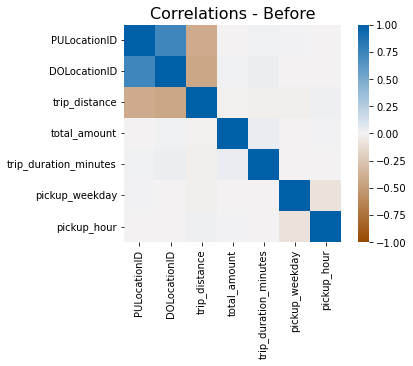

In [9]:
#plt.figure(figsize=(6,6))
corr       = df_taxi_2019_03_yg_cleaned.corr()
corr.index = df_taxi_2019_03_yg_cleaned.columns
sns.heatmap(corr, cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True), vmin=-1, vmax=1, square=True)
plt.title("Correlations - Before", fontsize=16)
plt.savefig('../doc/fig/correlations_before.pdf', bbox_inches='tight')
plt.show()

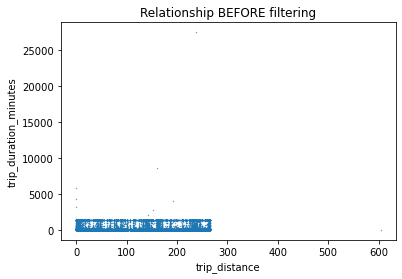

In [7]:
plt.scatter(df_taxi_2019_03_yg['trip_distance'], df_taxi_2019_03_yg['trip_duration_minutes'], s=0.1)
plt.xlabel('trip_distance')
plt.ylabel('trip_duration_minutes')
plt.title('Relationship BEFORE filtering')
plt.show()

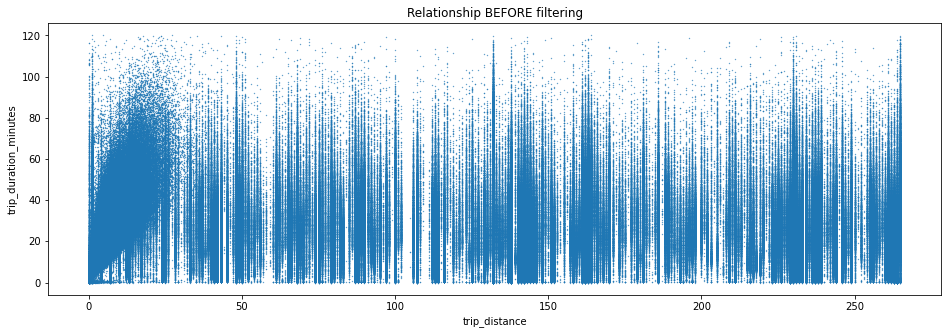

In [8]:
# ZOOMING IN...
plt.figure(figsize=(16,5))
plt.scatter(df_taxi_2019_03_yg[(df_taxi_2019_03_yg['trip_distance'] < 290) & (df_taxi_2019_03_yg['trip_duration_minutes'] < 120)]['trip_distance'],
            df_taxi_2019_03_yg[(df_taxi_2019_03_yg['trip_distance'] < 290) & (df_taxi_2019_03_yg['trip_duration_minutes'] < 120)]['trip_duration_minutes'], s=0.1)
plt.xlabel('trip_distance')
plt.ylabel('trip_duration_minutes')
plt.title('Relationship BEFORE filtering')
plt.show()

Just one view that shows how improper the data itself is. We do not know where all the nonsensical data comes from, i.e., what causes the vertical lines.

**Filter Features:**

i.e., remove rows in which there are features with nonsensical values.

In [10]:
t_lower = 5        # Minimum: 5
t_upper = 105      # Maximum: 1.75 hours => Average longest trip duration according to Google maps.
dist_upper = 55    # Maximum sensible distance => Analyses using Google maps showed that the furthest distances within
                   # the NYC taxi are cannot be further than 55 miles.
dist_lower = 0.3   # Trips must be longer than 0.3 miles (~500 metres)
amount_lower = 1   # Total fares cannot be less than 1$
min_passengers = 1 # At least 1 passenger has to be in the taxi
max_passengers = 5 # It is not possible to have more than 5 passengers in a car

In [11]:
# Filter routes
df_all_routes = df_taxi_2019_03_yg[(df_taxi_2019_03_yg['trip_duration_minutes'] < t_upper)   & \
                                   (df_taxi_2019_03_yg['trip_duration_minutes'] > t_lower)   & \
                                   (df_taxi_2019_03_yg['trip_distance'] < dist_upper)        & \
                                   (df_taxi_2019_03_yg['trip_distance'] > dist_lower)        & \
                                   (df_taxi_2019_03_yg['total_amount'] > amount_lower)       & \
                                   (df_taxi_2019_03_yg['passenger_count'] >= min_passengers) & \
                                   (df_taxi_2019_03_yg['passenger_count'] <= max_passengers)]

In [12]:
df_all_routes

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,total_amount,fleet,trip_duration,trip_duration_minutes,pickup_month,pickup_day_of_month,pickup_weekday,pickup_hour,pickup_minute
722,2019-03-01 00:18:02,2019-03-01 00:32:06,1,5,4,52.00,0.00,20.80,yellow,0 days 00:14:04,14.066667,3,1,4,0,18
1747,2019-03-01 00:53:13,2019-03-01 01:05:28,2,1,4,45.00,1.00,14.30,yellow,0 days 00:12:15,12.250000,3,1,4,0,53
2226,2019-03-01 00:39:05,2019-03-01 00:53:03,1,4,4,25.00,4.05,24.35,yellow,0 days 00:13:58,13.966667,3,1,4,0,39
2465,2019-03-01 00:18:47,2019-03-01 00:32:53,3,4,4,13.00,0.00,19.80,yellow,0 days 00:14:06,14.100000,3,1,4,0,18
6297,2019-03-01 00:10:54,2019-03-01 00:33:06,2,6,4,41.00,5.26,31.56,yellow,0 days 00:22:12,22.200000,3,1,4,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433641,2019-03-31 23:19:35,2019-03-31 23:31:03,95,56,5,2.18,0.00,11.30,green,0 days 00:11:28,11.466667,3,31,6,23,19
8433642,2019-03-31 23:35:06,2019-03-31 23:42:59,42,247,1,1.61,2.75,12.05,green,0 days 00:07:53,7.883333,3,31,6,23,35
8433643,2019-03-31 23:30:07,2019-03-31 23:45:36,42,238,1,3.22,0.00,16.55,green,0 days 00:15:29,15.483333,3,31,6,23,30
8433645,2019-03-31 23:51:29,2019-03-31 23:58:33,7,7,1,1.08,0.00,7.80,green,0 days 00:07:04,7.066667,3,31,6,23,51


**Drop unnecessary columns:**

It is very important to only drop columns **after** filtering because the filtering makes sure that only sensible rows are used. Ignoring a feature does not make the row better!

In [13]:
excluded_clms = ['pickup_datetime', 'dropoff_datetime', 'fleet', 'passenger_count', 'trip_duration', \
                 'pickup_day_of_month', 'pickup_month', 'tip_amount', 'pickup_minute']

df_all_routes = df_all_routes.drop(columns=excluded_clms, inplace=False)

In [24]:
#df_all_routes

In [8]:
# ATTENTION:
#    Seaborn (SNS) uses its own formatting which messes up the TuePlot settings!
import seaborn as sns

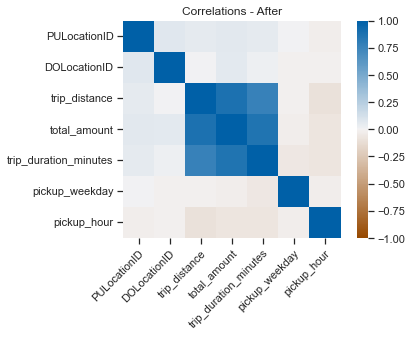

In [14]:
corr       = df_all_routes.corr()
corr.index = df_all_routes.columns

# Color blindness safe plot
sns.set(font_scale=1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True),
    square=True,
    annot=False
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.tick_params(left=True, bottom=True)

plt.title("Correlations - After")
plt.savefig('../doc/fig/correlations_after.pdf', bbox_inches='tight')
plt.show()

After filtering the data, i.e., when the features are restricted to more sensible values, different correlations emerge. This is confirmed by plotting, for example, trip distance against trip duration.<br>
However, our initial features of interest (i.e., temporal features like pickup_hour), which we intended to use for predictions are not correlated with the target value trip duration.

**Analyze Features:**

_Un-transformed Distributions:_

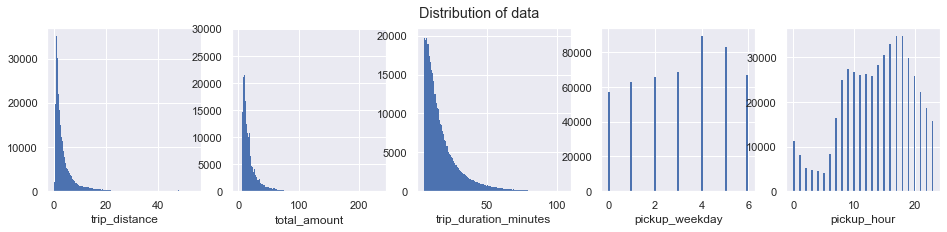

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16,3))
fig.suptitle('Distribution of data')
ax1.hist(df_all_routes['trip_distance'], bins='scott', linewidth=0)
ax1.set_xlabel('trip_distance')
ax2.hist(df_all_routes['total_amount'], bins='scott', linewidth=0)
ax2.set_xlabel('total_amount')
ax3.hist(df_all_routes['trip_duration_minutes'], bins='scott', linewidth=0)
ax3.set_xlabel('trip_duration_minutes')
ax4.hist(df_all_routes['pickup_weekday'], bins='scott', linewidth=0)
ax4.set_xlabel('pickup_weekday')
ax5.hist(df_all_routes['pickup_hour'], bins='scott', linewidth=0)
ax5.set_xlabel('pickup_hour')
plt.show()

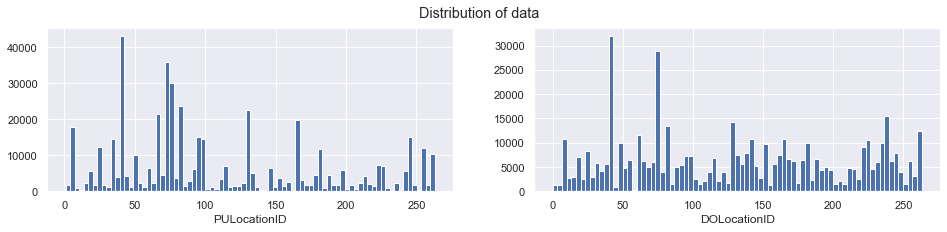

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
fig.suptitle('Distribution of data')
ax1.hist(df_all_routes['PULocationID'], bins='scott')
ax1.set_xlabel('PULocationID')
ax2.hist(df_all_routes['DOLocationID'], bins='scott')
ax2.set_xlabel('DOLocationID')
plt.show()

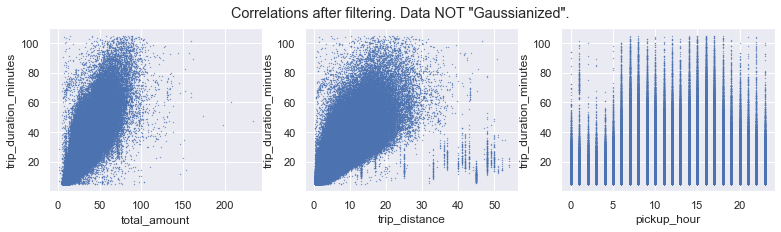

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,3))
fig.suptitle('Correlations after filtering. Data NOT "Gaussianized".')

ax1.scatter(df_all_routes['total_amount'], df_all_routes['trip_duration_minutes'], s=0.1)
ax1.set_xlabel('total_amount')
ax1.set_ylabel('trip_duration_minutes')

ax2.scatter(df_all_routes['trip_distance'], df_all_routes['trip_duration_minutes'], s=0.1)
ax2.set_xlabel('trip_distance')
ax2.set_ylabel('trip_duration_minutes')

ax3.scatter(df_all_routes['pickup_hour'], df_all_routes['trip_duration_minutes'], s=0.1)
ax3.set_xlabel('pickup_hour')
ax3.set_ylabel('trip_duration_minutes')

plt.show()

In [19]:
print('trip_duration_minutes: µ {:.2f} ± σ {:.2f} minutes'.format(df_all_routes['trip_duration_minutes'].std(),
                                                                  df_all_routes['trip_duration_minutes'].mean()))

print('total_amount         : µ {:.2f} ± σ {:.2f} $'.format(df_all_routes['total_amount'].std(),
                                                            df_all_routes['total_amount'].mean()))

print('trip_distance        : µ {:.2f} ± σ {:.2f} miles'.format(df_all_routes['trip_distance'].std(),
                                                                df_all_routes['trip_distance'].mean()))

trip_duration_minutes: µ 13.38 ± σ 17.94 minutes
total_amount         : µ 12.88 ± σ 18.42 $
trip_distance        : µ 4.47 ± σ 4.04 miles


Observation: There is a linear relationship in the data. However, the variance in the data is huge such that no useful prediction would be possible.

**"Gaussianize" Data:**

i.e., try to transform the target variable / features such that they are more similar to Gaussian shape &rarr; This would allow us to compute the Pearson correlation and correlation significance tests.

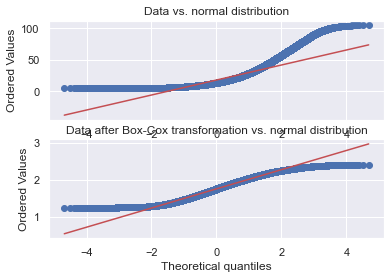

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df_all_routes['trip_duration_minutes'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Data vs. normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(df_all_routes['trip_duration_minutes'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Data after Box-Cox transformation vs. normal distribution')
plt.show()

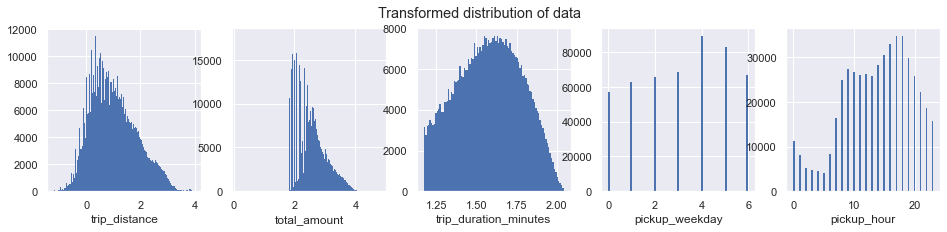

In [22]:
# Transformed distributions - Force to be as Gaussian as possible
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16,3))
fig.suptitle('Transformed distribution of data')

ax1.hist( stats.boxcox(df_all_routes['trip_distance'], 0), bins='scott', linewidth=0 )
ax1.set_xlabel('trip_distance')

ax2.hist( stats.boxcox(df_all_routes['total_amount'], -0.05), bins='scott', linewidth=0 )
ax2.set_xlabel('total_amount')

ax3.hist( stats.boxcox(df_all_routes['trip_duration_minutes'], -0.42) , bins='scott', linewidth=0 )
ax3.set_xlabel('trip_duration_minutes')

ax4.hist(df_all_routes['pickup_weekday'], bins='scott', linewidth=0)
ax4.set_xlabel('pickup_weekday')

ax5.hist(df_all_routes['pickup_hour'], bins='scott', linewidth=0)
ax5.set_xlabel('pickup_hour')
plt.show()

In [23]:
x0 = df_all_routes['PULocationID']
x1 = df_all_routes['DOLocationID']
x2 = stats.boxcox(df_all_routes['trip_distance'], -0.05)
x3 = stats.boxcox(df_all_routes['total_amount'], -0.05)
x4 = stats.boxcox(df_all_routes['trip_duration_minutes'], -0.42)
x5 = (df_all_routes['pickup_weekday']).values
x6 = (df_all_routes['pickup_hour']).values

X = np.column_stack((x0, x1, x2, x3, x4, x5, x6))

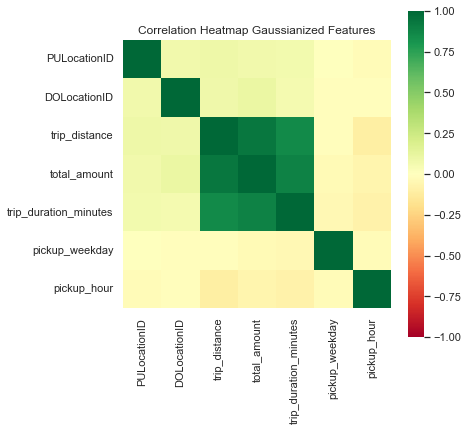

In [24]:
df = pd.DataFrame(X, columns=df_all_routes.columns)

plt.figure(figsize=(6, 6))
corr       = df.corr()
corr.index = df_all_routes.columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap Gaussianized Features", fontsize=12)
plt.show()

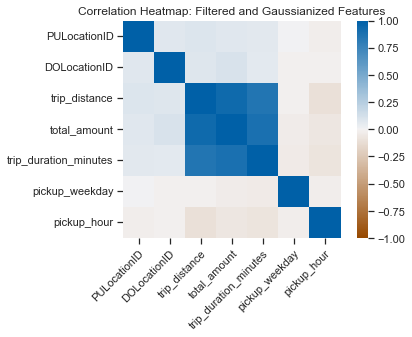

In [52]:
# Color blindness safe plot of Gaussianized features
sns.set(font_scale=1)
ax = sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 250, s=100, l=40, as_cmap=True),
    square=True,
    annot=False
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.tick_params(left=True, bottom=True)

plt.title("Correlation Heatmap: Filtered and Gaussianized Features")
plt.savefig('../doc/fig/correlations_gaussianized_features.pdf', bbox_inches='tight')
plt.show()

In [25]:
df.corr()

,PULocationID,DOLocationID,trip_distance,total_amount,trip_duration_minutes,pickup_weekday,pickup_hour
PULocationID,1.000000,0.072443,0.090956,0.074529,0.067947,0.004369,-0.025781
DOLocationID,0.072443,1.000000,0.083150,0.106819,0.058161,-0.009486,-0.009961
trip_distance,0.090956,0.083150,1.000000,0.930981,0.856003,-0.009045,-0.109314
total_amount,0.074529,0.106819,0.930981,1.000000,0.888226,-0.035798,-0.069325
trip_duration_minutes,0.067947,0.058161,0.856003,0.888226,1.000000,-0.044191,-0.078409
pickup_weekday,0.004369,-0.009486,-0.009045,-0.035798,-0.044191,1.000000,-0.029364
pickup_hour,-0.025781,-0.009961,-0.109314,-0.069325,-0.078409,-0.029364,1.000000


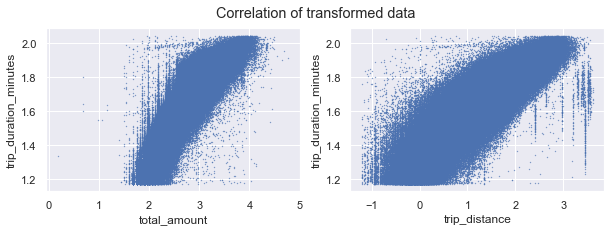

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Correlation of transformed data')

ax1.scatter(x3, x4, s=0.1)
ax1.set_xlabel('total_amount')
ax1.set_ylabel('trip_duration_minutes')

ax2.scatter(x2, x4, s=0.1)
ax2.set_xlabel('trip_distance')
ax2.set_ylabel('trip_duration_minutes')

plt.show()

---

**Tests for correlation:**

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Using_the_exact_distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

_Two-sided test for correlation based on the exact distribution of Pearson's r:_

* H0: **No** correlation between ``trip_duration_minutes`` and ``pickup_weekday``, i.e., they have no linear relationship.
* H1: ``trip_duration_minutes`` and ``pickup_weekday`` have significant correlation, thus, are related in some way.

In [28]:
pearson_coef, p_value = stats.pearsonr(x5, x4)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[5],
                                                                                              df.columns[4],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "pickup_weekday" and "trip_duration_minutes":  r = -0.0442 with a p-value of 0.0000


Observations:
* r $\approx 0$ indicates that there is no correlation between the trip duration in minutes and the day of the week a passenger enters a taxi.
* From the highly significant p-value of about $0$ from the two-sided test for correlation we conclude that there acutually is no correlation between the two features.
  * The r value obtained it _too unlikely_ to having occured by chance!

<p>&nbsp;</p>
Furhter tests for correlation between features that we initially intended to use as predictors in our linear regression model:

In [29]:
pearson_coef, p_value = stats.pearsonr(x6, x4)
print('Peason correlation between "{}" and "{}":  r = {:.4f} with a p-value of {:.4f}'.format(df.columns[6],
                                                                                              df.columns[4],
                                                                                              pearson_coef,
                                                                                              p_value))

Peason correlation between "pickup_hour" and "trip_duration_minutes":  r = -0.0784 with a p-value of 0.0000


---

**Vanilla linear regression:**

In [26]:
# Split data into shuffled training and test set

target_clm = 'trip_duration_minutes' # Determine the target variable.
X = df.loc[:, df.columns != target_clm]
y = df.loc[:, df.columns == target_clm]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [28]:
# Fit linear regression model: Raw features WITHOUT preprocessing
weights, y_pred = sklearn_regression(X_test, X_train, y_train)

MSE:  0.008291424002401812
r^2:  0.7994162338586733


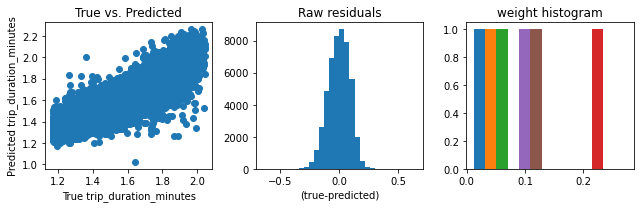

In [29]:
# Evaluate performance
plot_regression_results(y_test, y_pred, weights, target_clm)

**Linear regression with basis functions:**

In [57]:
# Fit linear regression model: Raw features WITHOUT preprocessing
weights, y_pred = sklearn_regression_bf(X_test, X_train, y_train, deg=3)

MSE:  0.00603608439931681
r^2:  0.8539767666915655


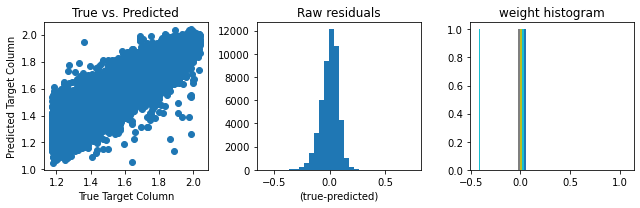

In [58]:
# Evaluate performance
plot_regression_results(y_test, y_pred, weights)

**Ridge regression with basis functions:**

Polynomial:

In [40]:
# Fit regularized linear regression model with basis functions: Raw features WITHOUT preprocessing
weights, y_pred = ridge_regression_bf(X_test, X_train, y_train, deg=3, alpha=1)

F:\Programme\anaconda3\envs\studium_ws21-22\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.14009e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


MSE:  0.0060346784248760535
r^2:  0.854010779624488


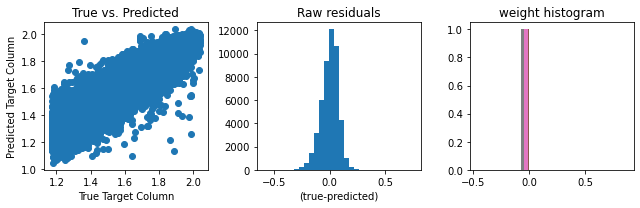

In [41]:
# Evaluate performance
plot_regression_results(y_test, y_pred, weights)

Root of features:

In [42]:
from sklearn.preprocessing import FunctionTransformer

In [52]:
transformer = FunctionTransformer(np.cbrt)

In [53]:
X_test_sqrt = transformer.transform(X_test)
X_train_sqrt = transformer.transform(X_train)

MSE:  0.007491314787741033
r^2:  0.8187722479226687


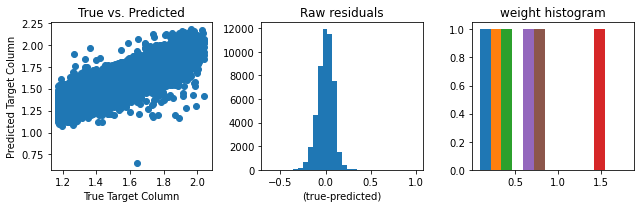

In [54]:
weights, y_pred = sklearn_regression(X_test_sqrt, X_train_sqrt, y_train)
plot_regression_results(y_test, y_pred, weights)

---

**QuantileTransformer to make distribution Gaussian:**

In [106]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
X = np.sort(df_all_routes['trip_distance'].normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit_transform(X)

In [226]:
df_all_routes.head(3)

,PULocationID,DOLocationID,trip_distance,total_amount,trip_duration_minutes,pickup_weekday,pickup_hour
722,1,5,52.0,20.80,14.066667,4,0
1747,2,1,45.0,14.30,12.250000,4,0
2226,1,4,25.0,24.35,13.966667,4,0


In [118]:
df_all_routes.shape

(494105, 12)

In [159]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_trans = quantile_transformer.fit_transform(df_all_routes)
quantile_transformer.quantiles_

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e-02, ...,
        5.01666667e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.00000000e+00, 1.40000000e-01, ...,
        5.03333333e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 3.00000000e+00, 3.00000000e-01, ...,
        5.05000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.60000000e+02, 2.63000000e+02, 3.13320721e+01, ...,
        8.59534535e+01, 6.00000000e+00, 2.30000000e+01],
       [2.60000000e+02, 2.63000000e+02, 4.20000000e+01, ...,
        9.21351351e+01, 6.00000000e+00, 2.30000000e+01],
       [2.63000000e+02, 2.63000000e+02, 5.40000000e+01, ...,
        1.04983333e+02, 6.00000000e+00, 2.30000000e+01]])

In [160]:
X_trans.shape

(494105, 7)

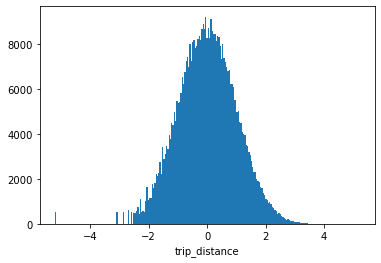

In [180]:
plt.hist(X_trans[:,4], bins='scott')
plt.xlabel('trip_distance')
plt.show()

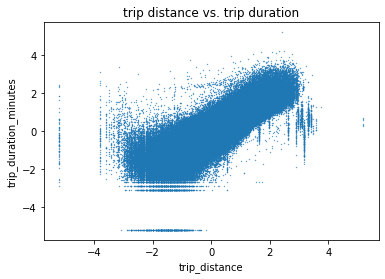

In [178]:
plt.scatter(X_trans[:,2], X_trans[:,4], s=0.1)
plt.title('trip distance vs. trip duration')
plt.xlabel('trip_distance')
plt.ylabel('trip_duration_minutes')
plt.plot();

[]

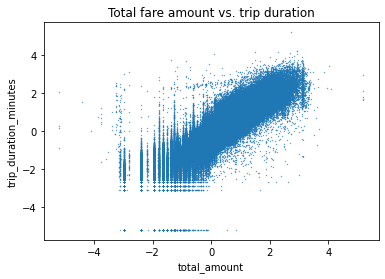

In [181]:
plt.scatter(X_trans[:,3], X_trans[:,4], s=0.1)
plt.title('Total fare amount vs. trip duration')
plt.xlabel('total_amount')
plt.ylabel('trip_duration_minutes')
plt.plot()

---

In [165]:
df = pd.DataFrame(X_trans, columns=df_all_routes.columns)

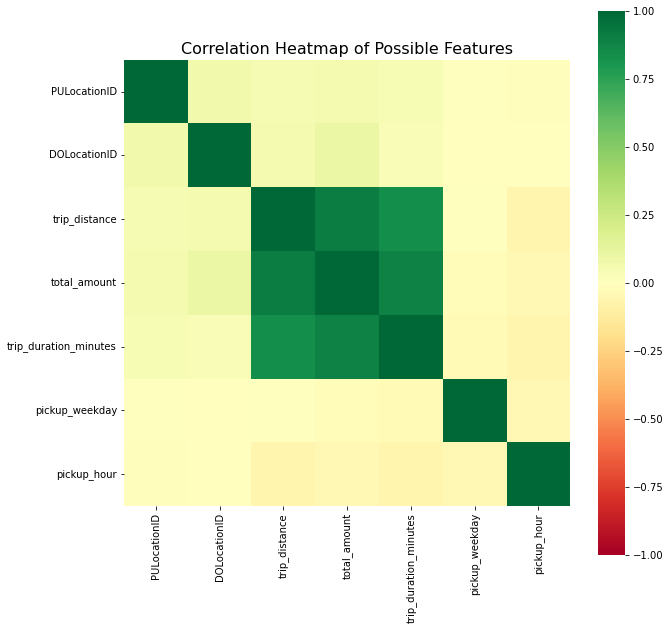

In [170]:
plt.figure(figsize=(10,10))
corr       = df.corr()
corr.index = df_all_routes.columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap of Possible Features", fontsize=16)
plt.show()